In [ ]:
# upgrade scipy to be able to use qmc
# after that automatically restarts the cell
import os
! pip install scipy --upgrade
os.kill(os.getpid(), 9)

In [1]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc

In [2]:
tf.keras.backend.set_floatx("float64")

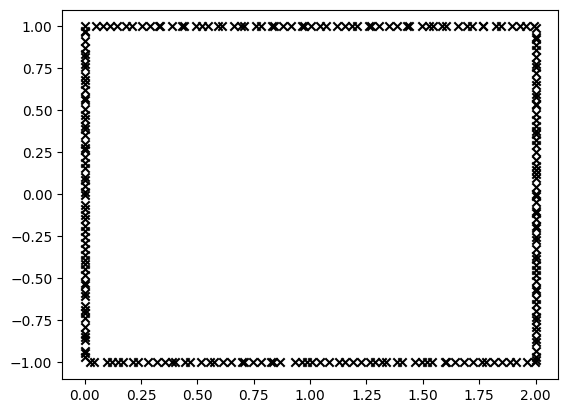

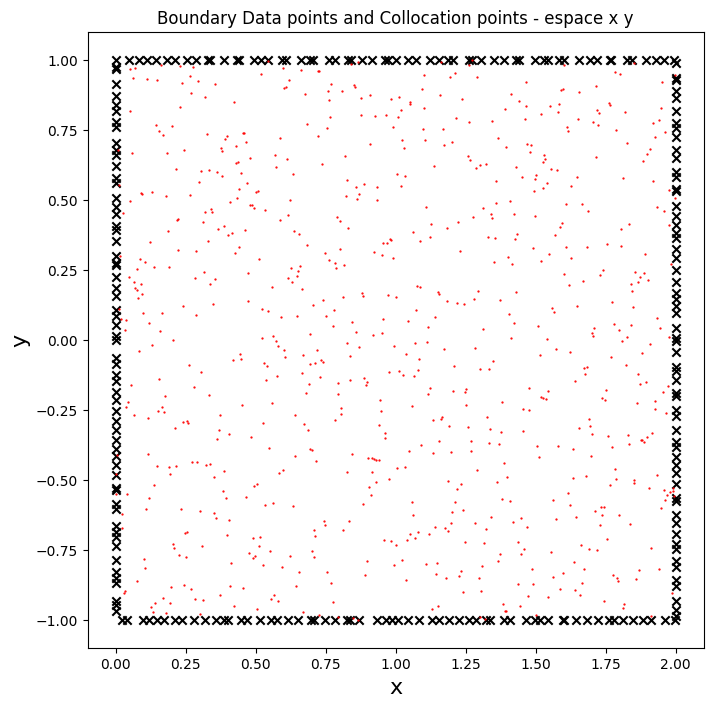

In [3]:
# .......................................................................
# We solve a Lane-Emden like equation in cartesian coordinates ... see paper
# We can impose different BC (Dirichlet, Neumann, Cauchy, ....)
# as derivatives can be also imposed on the boundaries .................
#......................................................................

# Among 2 cases, we can choose the wanted solution ... you must
# also choose the corresponding residual equation below with the 2 source terms.
# .............................................................................
@tf.function
def tru(x, y):
    tru = (1+x*x)*(1+y*y)
    #tru = 1+x*x*y*y
    return tru

@tf.function
def trudx(x, y):
    trudx=2*x+2*x*y*y
    #trudx=2*x*y*y
    return trudx

@tf.function
def trudy(x, y):
    trudy = 2*y+2*y*x*x
    #trudy=2*y*x*x
    return trudy

### data generation on boundaries .....
rmax=2
lmax= 1

n_bc = 4
n_data_per_bc = 60

# ....................................................
engine = qmc.LatinHypercube(d=1)
data = np.zeros([n_bc ,n_data_per_bc , 5])

for i, j in zip(range(n_bc), [0., 1., 0, 1.]):
    points = (engine.random(n=n_data_per_bc)[:, 0] - 0.) * 1
    #points = np.linspace(0, +1, n_data_per_bc)
    
    if i < 2:
        data[i, :, 0] = j + 0.
        data[i, :, 1] = points - 0.
    else:
        data[i, :, 0] = points + 0.
        data[i, :, 1] = j - 0.

data[:, :, 0] = rmax * data[:, :, 0] 
data[:, :, 1] = 2*lmax*data[:, :, 1] -1

# Values of data , derivative/x , and derivative/y ...
for j in range(0,n_data_per_bc):    
    # First left BC ......................    
    data[0,j,2]=tru(data[0,j,0], data[0,j,1])
    data[0,j,3]=trudx(data[0,j,0], data[0,j,1])
    data[0,j,4]=trudy(data[0,j,0], data[0,j,1])

    # Second right BC ....................
    data[1,j,2]=tru(data[1,j,0], data[1,j,1])
    data[1,j,3]=trudx(data[1,j,0], data[1,j,1])
    data[1,j,4]=trudy(data[1,j,0], data[1,j,1])
    
    # Bottom BC ....
    data[2,j,2]=tru(data[2,j,0], data[2,j,1])
    data[2,j,3]=trudx(data[2,j,0], data[2,j,1])
    data[2,j,4]=trudy(data[2,j,0], data[2,j,1])

    # Top BC ................
    data[3,j,2]=tru(data[3,j,0], data[3,j,1])
    data[3,j,3]=trudx(data[3,j,0], data[3,j,1])
    data[3,j,4]=trudy(data[3,j,0], data[3,j,1])
        
data = data.reshape(n_data_per_bc * n_bc, 5)

# t_d are data values, t_dx and td_y derivatives wrt x and y respectively .....
x_d, y_d, t_d, t_dx, t_dy = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4]])

plt.scatter(data[:,0], data[:,1], marker="x", c="k", label="BDP")
plt.show()

# DATA collocation points .................
Nc = 800
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = 1 * (colloc -0)

#
colloc[:, 0] = rmax*colloc[:, 0] 
colloc[:, 1] = 2*lmax*colloc[:, 1] -1


#
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])
#
plt.figure("", figsize=(8, 8))
plt.title("Boundary Data points and Collocation points - espace x y")
plt.scatter(data[:,0], data[:,1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:,0], colloc[:,1], s=1.5, marker=".", c="r", label="CP")
plt.xlabel("x",fontsize=16)
plt.ylabel("y",fontsize=16)
plt.axis("square")
plt.show()


#

x_c, y_c, x_d, y_d, t_d, t_dx, t_dy = map(lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
                             [x_c, y_c, x_d, y_d, t_d, t_dx, t_dy])

In [4]:
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=5, 
                neuron_per_layer=20, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

In [5]:
tf.keras.backend.clear_session()
model = DNN_builder(2, 1, 5, 20, "tanh")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

Model: "DNN-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 1)                 21    

In [6]:
# Predicted solution and correspondig derivatives ...
@tf.function
def u(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u

@tf.function
def uderx(x, y):
    u = model(tf.concat([x, y], axis=1))
    uderx = tf.gradients(u, x)[0]
    return uderx

@tf.function
def udery(x, y):
    u = model(tf.concat([x, y], axis=1))
    udery = tf.gradients(u,y)[0]
    return udery


In [7]:
# Choose the correct residual equation you want ..... 2 different source terms.
@tf.function
def f(x, y):
    u0 = u(x, y)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]

    F = x*y*u_xx + 2*y*u_x + x*y*u_yy + 2*x*u_y - 6*x*y*( 2 + x*x + y*y)  
    
    #F = x*y*u_xx + 1*y*u_x + x*y*u_yy + 1*x*u_y - 4*x*y*(x*x+y*y)
    
    retour = tf.reduce_mean(tf.square(F)) 
    return retour

In [8]:
# In order to calculate different MSE ........
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

@tf.function
def msex1(y, y_):
    # MSE only for boundary at x =  .....
    yr = tf.reshape(y,[n_bc, n_data_per_bc])
    yr_= tf.reshape(y_,[n_bc, n_data_per_bc])
    yrr = yr[0,:]
    yrr_= yr_[0,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour

@tf.function
def msex2(y, y_):
    # MSE only for boundary at x =  .....
    yr = tf.reshape(y,[n_bc, n_data_per_bc])
    yr_= tf.reshape(y_,[n_bc, n_data_per_bc])
    yrr = yr[1,:]
    yrr_= yr_[1,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour

@tf.function
def msey1(y, y_):
    # MSE only for 2 boundaries at y = .......
    yr = tf.reshape(y,[n_bc, n_data_per_bc])
    yr_= tf.reshape(y_,[n_bc, n_data_per_bc])
    yrr = yr[2,:]
    yrr_= yr_[2,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour

@tf.function
def msey2(y, y_):
    # MSE only for 2 boundaries at y = .......
    yr = tf.reshape(y,[n_bc, n_data_per_bc])
    yr_= tf.reshape(y_,[n_bc, n_data_per_bc])
    yrr = yr[3,:]
    yrr_= yr_[3,:]
    retour = tf.reduce_mean(tf.square(yrr-yrr_))    
    return retour


    0, 485.523129547
  200, 107.566467393
  400, 59.008713557
  600, 22.423942582
  800, 9.856699681
 1000, 5.455310479
 1200, 3.843329520
 1400, 2.871969613
 1600, 2.136312456
 1800, 1.563865573
 2000, 1.126490487
 2200, 0.805325084
 2400, 0.574610973
 2600, 0.410443734
 2800, 0.294878135
 3000, 0.212924602
 3200, 0.157244013
 3400, 0.118519854
 3600, 0.091155614
 3800, 0.071624939
 4000, 0.057518128
 4200, 0.047071910
 4400, 0.039048595
 4600, 0.032766345
 4800, 0.027630841
 5000, 0.023384174
 5200, 0.019798518
 5400, 0.016769371
 5600, 0.014883769
 5800, 0.012045014
 6000, 0.010247382
 6200, 0.008743215
 6400, 0.007513058
 6600, 0.006496415
 6800, 0.005672713
 7000, 0.005155329
 7200, 0.004765623
 7400, 0.004015780
 7600, 0.003649665
 7800, 0.003343256
 8000, 0.003091164
 8200, 0.003664593
 8400, 0.003863840
 8600, 0.002510801
 8800, 0.002666143
 9000, 0.002198763
 9200, 0.002091221
 9400, 0.001938659
 9600, 0.001828180
 9800, 0.002627500
10000, 0.001636487
10200, 0.001540653
10400,

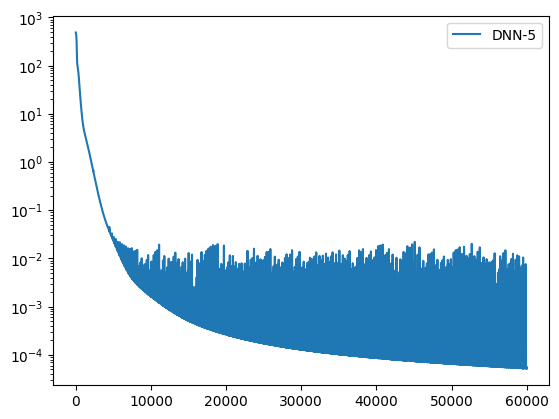

In [9]:
loss = 0
epochs = 60000
opt = tf.keras.optimizers.legacy.Adam(learning_rate=3e-4)
epoch = 0
loss_values = np.array([])
L_values = np.array([])
l_values = np.array([])

#
start = time.time()
#
for epoch in range(epochs):
    with tf.GradientTape() as tape:

        T_ = u(x_d, y_d)
        Tderx_= uderx(x_d, y_d)
        Tdery_ = udery(x_d, y_d)
        
        L = 1*f(x_c, y_c)
        
        l = 1*msex1(t_d, T_)+ 0*msey1(t_d, T_) + 0*msey2(t_d, T_) + 1*msex2(t_d, T_)
        
        #l = 1*msex1(t_d, T_) +  msex2(t_d, T_)
        #l = mse(t_d,T_)
        l = l+ 1*msex1(t_dx, Tderx_) + 0*msey1(t_dx, Tderx_) + 0*msey2(t_dx, Tderx_) + 1*msex2(t_dx, Tderx_)
        
        l = l + 0*msex1(t_dy, Tdery_) + 0*msey1(t_dy, Tdery_) + 0*msey2(t_dy, Tdery_) + 0*msex2(t_dy, Tdery_)

        #l = l + mse(t_dy, Tdery_)
        #l= msex1(t_d, T_) + msex2(t_d, T_)  

        #l = mse(t_d,T_) + 0*mse(t_dx, Tderx_) + 0*mse(t_dy, Tdery_)
        loss = L + l 
        
    g = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(g, model.trainable_weights))
    loss_values = np.append(loss_values, loss)
    L_values = np.append(L_values, L)
    l_values = np.append(l_values, l)
        
    if epoch % 200 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {loss.numpy():.9f}")
#
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
#
plt.semilogy(loss_values, label=model.name)
plt.legend()

In [158]:
n = 200
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])


/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_16822/407384235.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_16822/407384235.py:81: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


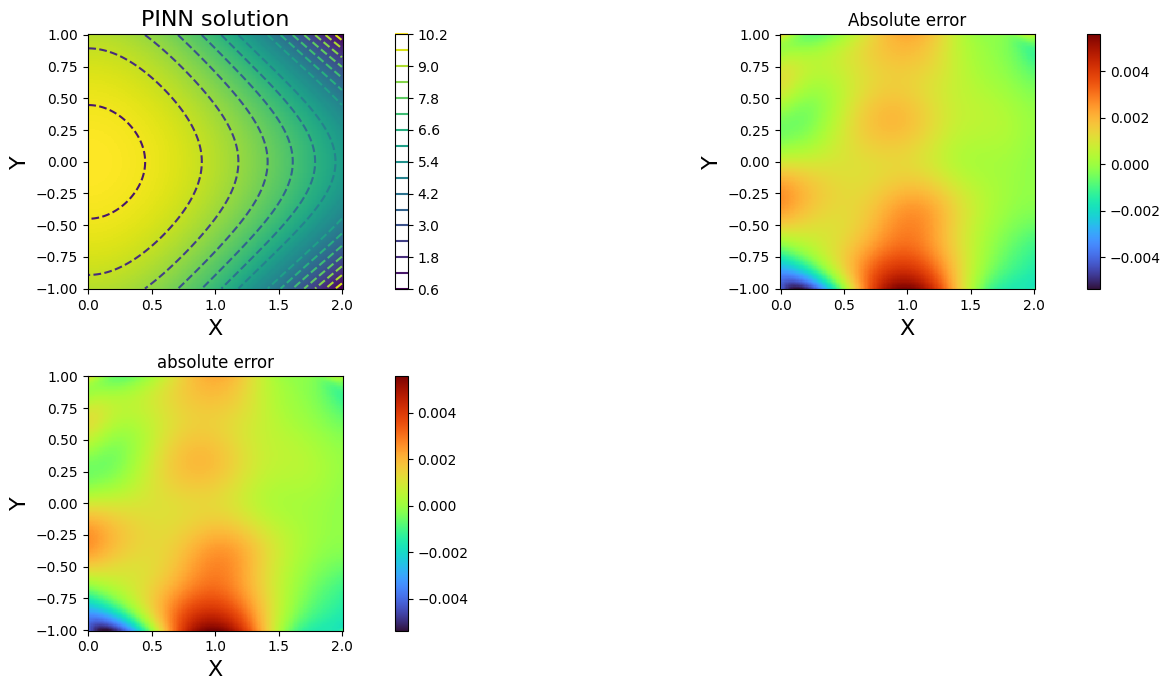

In [159]:
### For plotting the results ......
#plt.figure("", figsize=(16, 8))
plt.figure("", figsize=(14, 7))
#
lim1=lmax
lim2=rmax

X = np.linspace(0.000, lim2, n)
Y = np.linspace(-lim1, lim1, n)
X0, Y0 = np.meshgrid(X, Y)


X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)

# Predicted solutions ....
S = u(X_T, Y_T)
S = S.numpy().reshape(n, n)
#

S2=S
plt.subplot(221)
#S2[S < 0] =  0.00000000000000000
plt.pcolormesh(X0, Y0, S2, cmap="viridis_r")
plt.contour(X0, Y0, S2,15,linestyles='dashed',linewidths=1.5)
plt.colorbar(pad=-0.25)
#plt.scatter(data[:, 0], data[:, 1], marker=".", c="r", label="BDP")
#plt.scatter(colloc[:,0], colloc[:,1], marker=".", c="b")
plt.xlabel("X",fontsize=16)
plt.ylabel("Y",fontsize=16)
plt.xlim(0, lim2)
plt.ylim(0, lim1)
plt.title("PINN solution",fontsize=16)
plt.tight_layout()
plt.axis("square")

#plt.show()
#

#plt.figure("", figsize=(14, 7))

# Exact solution ...
TT = tru(X0,Y0)
# error relative ...
TT2 = (TT -S2)/TT

plt.subplot(222)
plt.pcolormesh(X0, Y0, TT-S2, cmap="turbo")
#plt.contour(X0, Y0, TT2,21)
plt.colorbar(pad=-0.25)
plt.xlabel("X",fontsize=16)
plt.ylabel("Y",fontsize=16)
plt.xlim(0, lim2)
plt.ylim(-lim1, lim1)
plt.title("Absolute error")
plt.tight_layout()
plt.axis("square")

#plt.show()
#

#plt.figure("", figsize=(14, 7))

# TRue exact solution ....
TT = tru(X0,Y0)

# Error .....absolute
TT2 = (TT -S2)

plt.subplot(223)
plt.pcolormesh(X0, Y0, TT2, cmap="turbo")
#plt.contour(X0, Y0, TT2,21)
plt.colorbar(pad=-0.25)
plt.xlabel("X",fontsize=16)
plt.ylabel("Y",fontsize=16)
plt.xlim(0, lim2)
plt.ylim(-lim1, lim1)
plt.title("absolute error")
plt.tight_layout()
plt.axis("square")

plt.show()



[0, 39, 79, 119, 159, 199]


/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_16822/4208211884.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_16822/4208211884.py:55: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


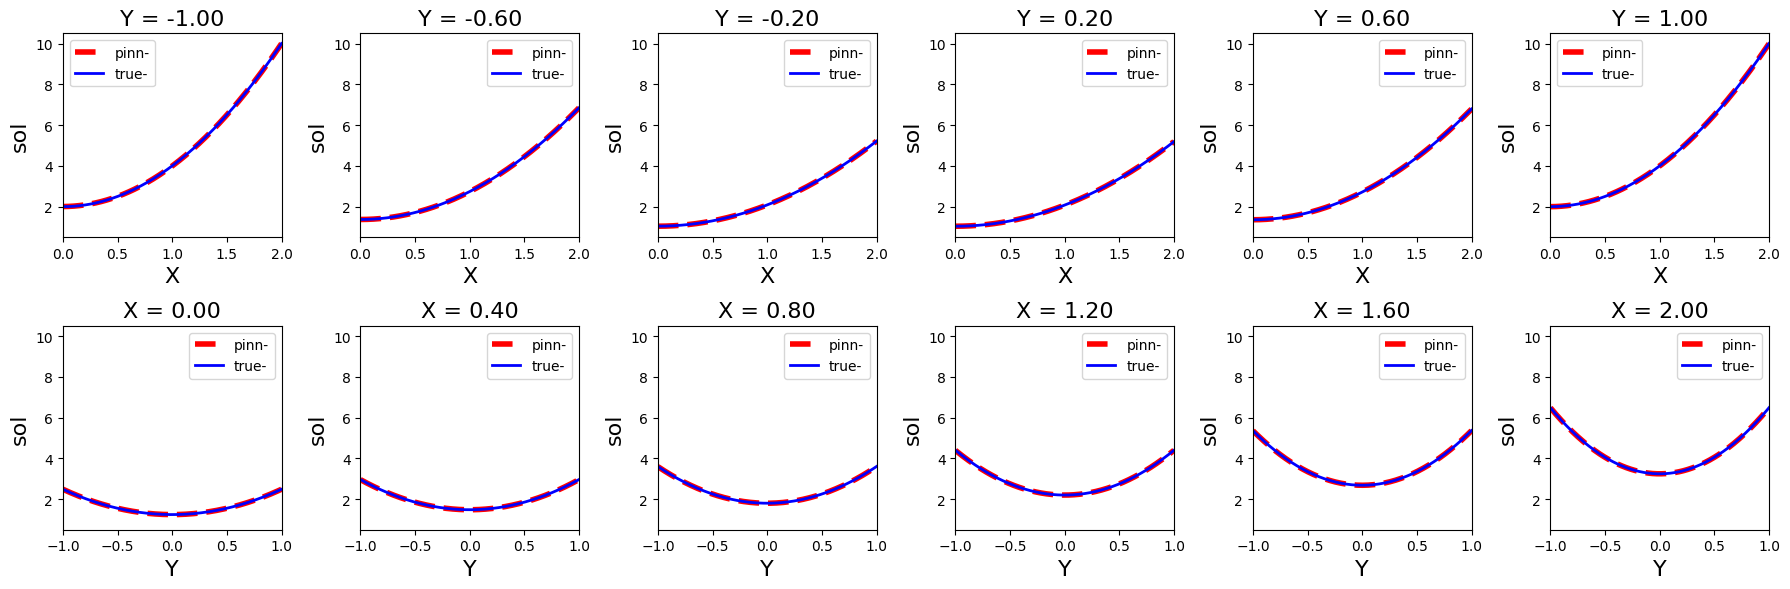

In [156]:
# To compare cuts ........ manetic field B_y ...
X = np.linspace(0, lim2, n)
Y = np.linspace(-lim1, +lim1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)

x = np.linspace(0, lim2, n)
y = np.linspace(-lim1, lim1, n)
x, y = np.meshgrid(x, y)

# predicted solution
Scomp = u(X_T, Y_T)
S = Scomp
S = S.numpy().reshape(n, n)
S_ = S.reshape([n, n])
# True B_y .................
T_ = tru(x,y)

height = 3
frames_val = np.array([-1, -0.6, -0.2, 0.2, 0.6, 1])
frames = [*map(int, (frames_val + 1)/lmax/2 * (n-1))]

print (frames)

fig = plt.figure("", figsize=(len(frames)*height, 2*height))

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), i+1)
    plt.title(f"Y = {frames_val[i]:.2f}",fontsize=16)
    plt.plot(X0[var_index, :], S_[var_index,:], "r--", lw=4., label="pinn-")
    plt.plot(X0[var_index, :], T_[var_index,:], "b", lw=2., label="true-")
    plt.ylim(0.5, 10.5)
    plt.xlim(0, lim2)
    plt.xlabel("X",fontsize=16)
    plt.ylabel("sol",fontsize=16)
    plt.tight_layout()
    plt.legend()

height = 3
frames_val = np.array([0, 0.4, 0.8, 1.2,1.6, 2])
frames = [*map(int, (frames_val + 1)/rmax/2 * (n-1))]

for i, var_index in enumerate(frames):
    plt.subplot(2, len(frames), len(frames) + i+1)
    plt.title(f"X = {frames_val[i]:.2f}",fontsize=16)
    plt.plot(Y0[:, var_index], S_[:,var_index], "r--", lw=4., label="pinn-")
    plt.plot(Y0[:, var_index], T_[:,var_index], "b", lw=2., label="true-")
    plt.ylim(0.5, 10.5)
    plt.xlim(-lim1, lim1)
    plt.xlabel("Y",fontsize=16)
    plt.ylabel("sol",fontsize=16)
    plt.tight_layout()
    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


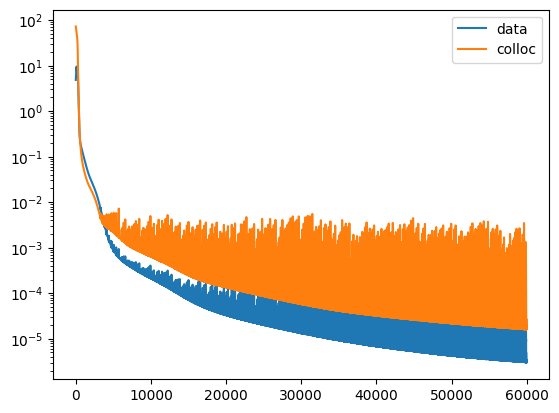

In [43]:
plt.legend()
plt.semilogy(l_values, label='data')
plt.legend()

plt.semilogy(L_values, label='colloc')
plt.legend()